In [13]:
# My code
import neuraltda.simpComp as sc
import neuraltda.topology2 as tp2
import neuraltda.spectralAnalysis as sa
from ephys import rasters

# System Libs
from importlib import reload
import pickle
import glob
import os

# Scientific Libs
import numpy as np
from scipy.optimize import brentq
import tqdm

# Plotting libs
import matplotlib.pyplot as plt
import seaborn as sns

# Set some parameters
sns.set_context('poster')
sns.set_style('white')
%matplotlib inline
reload(sa)
reload(sc)

<module 'neuraltda.simpComp' from '/home/brad/code/NeuralTDA/neuraltda/simpComp.py'>

In [14]:
nsamples2 = 10
d = 1

def poisson_model_loss_generic(a, beta, E_data, ncells, nwin, n_samples, metric_func):
    # take a probabilities,
    # generate random configurations, 
    # measure KL divergence to data, 
    # report loss
    
    # Declare variables
    KLsave = []
    JSsave = []
    probs = (a*np.ones((ncells, 1)))

    # Generate new spike trains
    samples = np.random.rand(ncells, nwin, n_samples)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, n_samples))
    binMatsamples = np.greater(probmat, samples).astype(int)
    
    # Compute simplicial complex 
    SCGs = []
    for ind in range(n_samples):
        
        # Compute SCG for test spike trains
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        E_model = sc.simplicialChainGroups(msimps)

        # Compute Laplacians for target and tests
        Lsamp = sc.compute_laplacian(E_model, d)
        Ldata = sc.compute_laplacian(E_data, d)
        
        # Reconcile Laplacian dimensions
        if (np.size(Lsamp) > np.size(Ldata)):
            (Ldata, Lsamp) = sc.reconcile_laplacians(Ldata, Lsamp)
        else:
            (Lsamp, Ldata) = sc.reconcile_laplacians(Lsamp, Ldata)
            
        # Compute KL divergence for this test spike train and store it. 
        KLsave.append(metric_func(Ldata, Lsamp, beta))
    
    # Compute mean and stderr over all the test spike trains
    m = np.mean(KLsave)
    std = np.std(KLsave)
    stderr = std / np.sqrt(n_samples)
    return (m, stderr)


def loss_new(a, beta):
    # take a probabilities,
    # generate random configurations, 
    # measure KL divergence to data, 
    # report loss
    
    # Declare variables
    KLsave = []
    JSsave = []
    probs = (a*np.ones((ncells, 1)))

    # Generate new spike trains
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    
    # Compute simplicial complex 
    SCGs = []
    for ind in range(nsamples2):
        
        # Compute SCG for test spike trains
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        # Compute Laplacians for target and tests
        Lsamp = sc.compute_laplacian(Emodel, d)
        Ldata = sc.compute_laplacian(Edata, d)
        
        # Reconcile Laplacian dimensions
        if (np.size(Lsamp) > np.size(Ldata)):
            (Ldata, Lsamp) = sc.reconcile_laplacians(Ldata, Lsamp)
        else:
            (Lsamp, Ldata) = sc.reconcile_laplacians(Lsamp, Ldata)
            
        # Compute density matrices
        rsamp = sc.densityMatrix(Lsamp, beta)
        rdata = sc.densityMatrix(Ldata, beta)
        
        # Compute KL divergence for this test spike train and store it. 
        KLsave.append(sc.KLdivergence(rdata, rsamp))
    
    # Compute mean and stderr over all the test spike trains
    m = np.mean(KLsave)
    std = np.std(KLsave)
    stderr = std / np.sqrt(nsamples2)
    return (m, stderr)

def loss_new_lap(a, beta):
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = (a*np.ones((ncells, 1)))
    KLsave=[]
    JSsave = []
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    SCGs = []
    for ind in range(nsamples2):
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        #Ddata = sc.boundaryOperatorMatrix(Edata, d)
        #Dsamp = sc.boundaryOperatorMatrix(Emodel, d)
        Lsamp = sc.compute_laplacian(Emodel, d)
        Ldata = sc.compute_laplacian(Edata, d)
        if (np.size(Lsamp) > np.size(Ldata)):
            (Ldata, Lsamp) = sc.reconcile_laplacians(Ldata, Lsamp)
        else:
            (Lsamp, Ldata) = sc.reconcile_laplacians(Lsamp, Ldata)
        #rsamp = sc.densityMatrix(Lsamp, beta)
        
        #rdata = sc.densityMatrix(Ldata, beta)
        #print(Ldata)
        #print(rsamp)
        #print(rdata)
        
        #KLsave.append(sc.KLdivergence_matrixlog(rdata, rsamp))
        #JSsave.append(sc.JSdivergence(rdata, rsamp))
        KLsave.append(sc.KLdivergence_lap(Ldata, Lsamp, beta))
    m = np.mean(KLsave)
    std = np.std(KLsave)
    stderr = std / np.sqrt(nsamples2)
    return (m, stderr)

def loss_new_likelihood(a, beta):
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = (a*np.ones((ncells, 1)))
    KLsave=[]
    JSsave = []
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    SCGs = []
    for ind in range(nsamples2):
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        #Ddata = sc.boundaryOperatorMatrix(Edata, d)
        #Dsamp = sc.boundaryOperatorMatrix(Emodel, d)
        Lsamp = sc.compute_laplacian(Emodel, d)
        Ldata = sc.compute_laplacian(Edata, d)
        if (np.size(Lsamp) > np.size(Ldata)):
            (Ldata, Lsamp) = sc.reconcile_laplacians(Ldata, Lsamp)
        else:
            (Lsamp, Ldata) = sc.reconcile_laplacians(Lsamp, Ldata)
        rsamp = sc.densityMatrix(Lsamp, beta)
        
        rdata = sc.densityMatrix(Ldata, beta)
        #print(Ldata)
        #print(rsamp)
        #print(rdata)
        
        #KLsave.append(sc.KLdivergence_matrixlog(rdata, rsamp))
        #JSsave.append(sc.JSdivergence(rdata, rsamp))
        KLsave.append(sc.Likelihood(rdata, rsamp))
    m = np.mean(KLsave)
    std = np.std(KLsave)
    stderr = std / np.sqrt(nsamples2)
    return (m, stderr)

def loss_new_JS(a, beta):
    #Calculate JS according to Biam Dedom, using entropy
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = (a*np.ones((ncells, 1)))
    KLsave=[]
    JSsave = []
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    SCGs = []
    for ind in range(nsamples2):
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        #Ddata = sc.boundaryOperatorMatrix(Edata, d)
        #Dsamp = sc.boundaryOperatorMatrix(Emodel, d)
        Lsamp = sc.compute_laplacian(Emodel, d)
        Ldata = sc.compute_laplacian(Edata, d)
        if (np.size(Lsamp) > np.size(Ldata)):
            (Ldata, Lsamp) = sc.reconcile_laplacians(Ldata, Lsamp)
        else:
            (Lsamp, Ldata) = sc.reconcile_laplacians(Lsamp, Ldata)
        rsamp = sc.densityMatrix(Lsamp, beta)
        
        rdata = sc.densityMatrix(Ldata, beta)
        #print(Ldata)
        #print(rsamp)
        #print(rdata)
        
        #KLsave.append(sc.KLdivergence_matrixlog(rdata, rsamp))
        JSsave.append(sc.JSdivergence(rdata, rsamp))
        KLsave.append(sc.KLdivergence(rdata, rsamp))
    m = np.mean(KLsave)
    mJS = np.mean(JSsave)
    std = np.std(KLsave)
    stdJS = np.std(JSsave)
    stderr = std / np.sqrt(nsamples2)
    stderrJS = stdJS / np.sqrt(nsamples2)
    return (m, mJS, stderr, stderrJS)

def loss_new_KLmatlog(a, beta):
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = (a*np.ones((ncells, 1)))
    KLsave=[]
    JSsave = []
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    SCGs = []
    for ind in range(nsamples2):
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        #Ddata = sc.boundaryOperatorMatrix(Edata, d)
        #Dsamp = sc.boundaryOperatorMatrix(Emodel, d)
        Lsamp = sc.compute_laplacian(Emodel, d)
        Ldata = sc.compute_laplacian(Edata, d)
        if (np.size(Lsamp) > np.size(Ldata)):
            (Ldata, Lsamp) = sc.reconcile_laplacians(Ldata, Lsamp)
        else:
            (Lsamp, Ldata) = sc.reconcile_laplacians(Lsamp, Ldata)
        rsamp = sc.densityMatrix(Lsamp, beta)
        
        rdata = sc.densityMatrix(Ldata, beta)
        #print(Ldata)
        #print(rsamp)
        #print(rdata)
        
        KLsave.append(sc.KLdivergence_matrixlog(rdata, rsamp))
        #JSsave.append(sc.JSdivergence(rdata, rsamp))
        #KLsave.append(sc.KLdivergence(rdata, rsamp))
    m = np.mean(KLsave)
    std = np.std(KLsave)
    stderr = std / np.sqrt(nsamples2)
    return (m, stderr)

def loss_old_JS(a, beta):
    #Calculate JS according to Biam Dedom, using entropy
    # take a set of probabilities, generate random configurations, measure KL divergence to data, report loss
    probs = (a*np.ones((ncells, 1)))
    KLsave=[]
    JSsave = []
    samples = np.random.rand(ncells, nwin, nsamples2)
    probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
    probmat = np.tile(probmat, (1, 1, nsamples2))
    binMatsamples = np.greater(probmat, samples).astype(int)
    SCGs = []
    for ind in range(nsamples2):
        msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
        Emodel = sc.simplicialChainGroups(msimps)

        #Ddata = sc.boundaryOperatorMatrix(Edata, d)
        #Dsamp = sc.boundaryOperatorMatrix(Emodel, d)
        Lsamp = sc.compute_laplacian(Emodel, d)
        Ldata = sc.compute_laplacian(Edata, d)
        if (np.size(Lsamp) > np.size(Ldata)):
            (Ldata, Lsamp) = sc.reconcile_laplacians(Ldata, Lsamp)
        else:
            (Lsamp, Ldata) = sc.reconcile_laplacians(Lsamp, Ldata)
        rsamp = sc.densityMatrix(Lsamp, beta)
        
        rdata = sc.densityMatrix(Ldata, beta)
        #print(Ldata)
        #print(rsamp)
        #print(rdata)
        
        #KLsave.append(sc.KLdivergence_matrixlog(rdata, rsamp))
        JSsave.append(sc.JSdivergence_old(rdata, rsamp))
        #KLsave.append(sc.KLdivergence(rdata, rsamp))
    #m = np.mean(KLsave)
    mJS = np.mean(JSsave)
    #std = np.std(KLsave)
    stdJS = np.std(JSsave)
    #stderr = std / np.sqrt(nsamples2)
    m=0
    stderr=0
    stderrJS = stdJS / np.sqrt(nsamples2)
    return (m, mJS, stderr, stderrJS)

In [18]:
# Generate binary matrix with given probabilities for each "cell"
ncells = 20
nwin = 1000
a = 0.02
probs = (a*np.ones((ncells, 1)))
nsamples = 1
samples = np.random.rand(ncells, nwin, nsamples)
probmat = np.tile(probs,  (1, nwin))[:, :, np.newaxis]
probmat = np.tile(probmat, (1, 1, nsamples))
binMatsamples = np.greater(probmat, samples).astype(int)

# Compute SCG for each sample
SCGs = []
for ind in range(nsamples):
    msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs.append(E)
Edata = SCGs[0]


est_save = []
ntrials = 1
X = np.linspace(0.0005, 0.08, 100)

beta = -0.15

for t in range(ntrials):
    #print(t)
    KL=[]
    JS = []
    KLerr = []
    JSerr = []
    for x in tqdm.tqdm(X):
        #print(x)
        (m, stderr) = loss_new_lap(x, beta)
        KL.append(m)
        KLerr.append(stderr)
        
    
    index_min = np.argmin(KL)
    est_save.append(X[index_min])

  3%|▎         | 3/100 [00:00<00:04, 21.77it/s]

error1
error2
error1
error2
error1
error2
error1
error2
error1
error2
error1
error2
error1
error2
error1
error2
error1
error2
error1
error2
error1
error2
error1
error2
error2
error1
error2
error2
error2
error2
error2
error1
error2
error1
error2
error2
error2
error2
error1
error2
error2
error1
error2
error2
error1
error2
error1
error2
error2
error2
error2
error2
error1
error2
error1
error2
error2
error1
error2
error2
error2
error2
error2


  8%|▊         | 8/100 [00:00<00:04, 21.40it/s]

error2
error2
error2
error1
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2


 11%|█         | 11/100 [00:00<00:04, 21.73it/s]

error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2
error2


 15%|█▌        | 15/100 [00:00<00:04, 17.05it/s]

error2
error2
error2
error2
error2
error2


 19%|█▉        | 19/100 [00:01<00:04, 16.77it/s]

error2
error2
error2


100%|██████████| 100/100 [00:31<00:00,  1.32it/s]


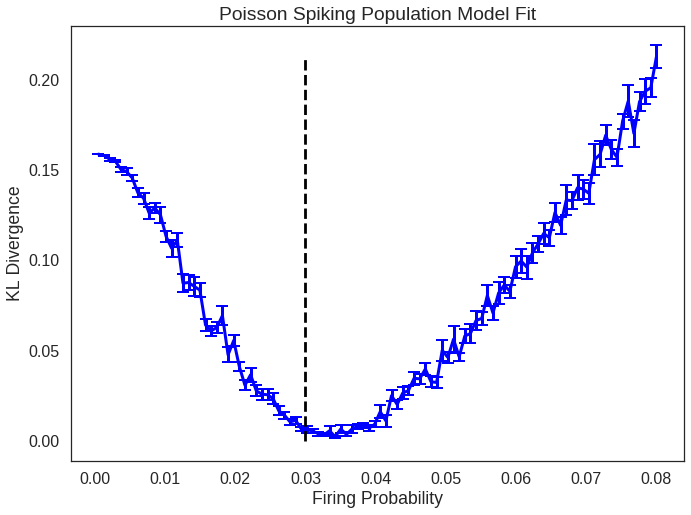

In [4]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2, fmt='b')
#plt.ylim(0, 0.46)
plt.plot(a*np.ones((20, 1)), np.linspace(0,np.amax(KL), 20), 'k--')
plt.xlabel('Firing Probability')
plt.ylabel('KL Divergence')
plt.title('Poisson Spiking Population Model Fit')
#plt.savefig('/Users/brad/PoissonFit-{}.pdf'.format(a), format='pdf')

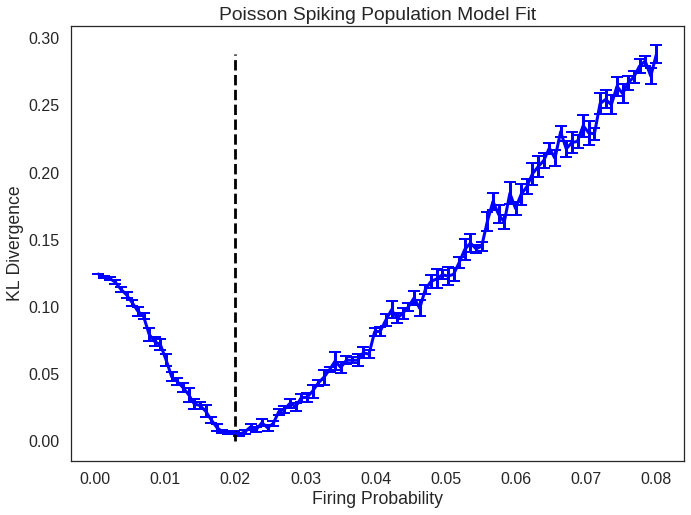

In [19]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2, fmt='b')

plt.plot(a*np.ones((20, 1)), np.linspace(0, np.amax(KL), 20), 'k--')
#plt.xlim([0, 0.04])
#plt.ylim(0, 0.75)
plt.xlabel('Firing Probability')
plt.ylabel('KL Divergence')
plt.title('Poisson Spiking Population Model Fit')
#plt.savefig('/Users/brad/PoissonFit-{}.pdf'.format(a), format='pdf')

In [178]:
np.mean(np.sum(binMatsamples[:, :, 0], axis=1) / nwin)

0.020300000000000006

In [88]:
# Compute SCG for each sample
SCGs = []
for ind in range(nsamples):
    msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs.append(E)
Edata = SCGs[0]


est_save = []
ntrials = 1
X = np.linspace(0.005, 0.06, 20)

beta = -1.

#likelihood

for t in range(ntrials):
    print(t)
    KL=[]
    JS = []
    KLerr = []
    JSerr = []
    for x in X:
        print(x)
        (m, stderr) = loss_new_likelihood(x, beta)
        KL.append(m)
        KLerr.append(stderr)
        
    
    index_min = np.argmin(KL)
    est_save.append(X[index_min])

0
0.005
error2
error2
error2
error2
error2
0.00789473684211
error2
error2
error2
0.0107894736842
error2
error2
0.0136842105263
0.0165789473684
0.0194736842105
0.0223684210526
0.0252631578947
0.0281578947368
0.0310526315789
0.0339473684211
0.0368421052632
0.0397368421053
0.0426315789474
0.0455263157895
0.0484210526316
0.0513157894737
0.0542105263158
0.0571052631579
0.06


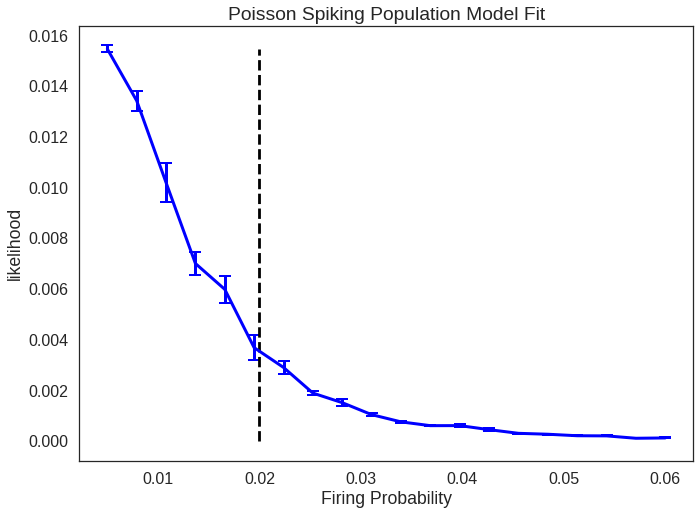

In [89]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2, fmt='b')
#plt.ylim(0, 0.46)
plt.plot(a*np.ones((20, 1)), np.linspace(0, np.amax(KL), 20), 'k--')
plt.xlabel('Firing Probability')
plt.ylabel('likelihood')
plt.title('Poisson Spiking Population Model Fit')
#plt.savefig('/Users/brad/PoissonFit-{}.pdf'.format(a), format='pdf')

In [90]:
# Compute SCG for each sample
SCGs = []
for ind in range(nsamples):
    msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs.append(E)
Edata = SCGs[0]


est_save = []
ntrials = 1
X = np.linspace(0.005, 0.05, 20)

beta = -1

for t in range(ntrials):
    print(t)
    KL=[]
    JS = []
    KLerr = []
    JSerr = []
    for x in X:
        print(x)
        (m, mjs, stderr, stderrjs) = loss_new_JS(x, beta)
        KL.append(m)
        JS.append(mjs)
        KLerr.append(stderr)
        JSerr.append(stderrjs)
        
    
    index_min = np.argmin(KL)
    est_save.append(X[index_min])

0
0.005
error2
error2
error2
error2
error2
0.00736842105263
error2
error2
error2
0.00973684210526
error2
error2
0.0121052631579
0.0144736842105
0.0168421052632
0.0192105263158
0.0215789473684
0.0239473684211
0.0263157894737
0.0286842105263
0.0310526315789
0.0334210526316
0.0357894736842
0.0381578947368
0.0405263157895
0.0428947368421
0.0452631578947
0.0476315789474
0.05


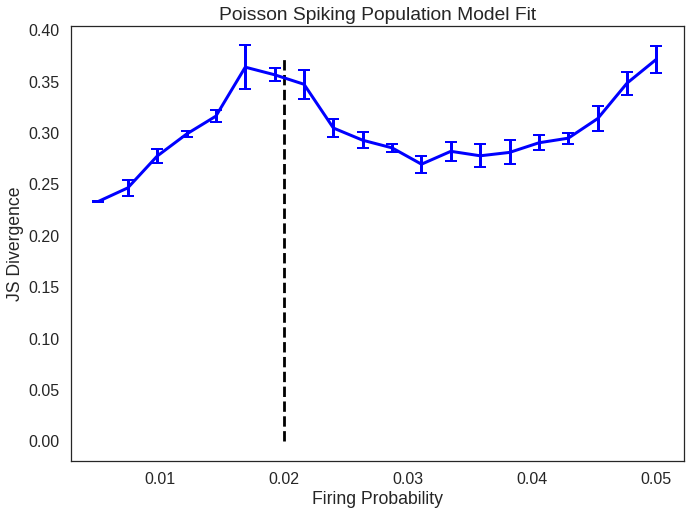

In [91]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, JS, yerr=JSerr, linewidth=3, capsize=6, capthick=2, fmt='b')
#plt.ylim(0, 0.46)
plt.plot(a*np.ones((20, 1)), np.linspace(0, np.amax(JS), 20), 'k--')
plt.xlabel('Firing Probability')
plt.ylabel('JS Divergence')
plt.title('Poisson Spiking Population Model Fit')
#plt.savefig('/Users/brad/PoissonFit-{}.pdf'.format(a), format='pdf')

In [105]:
# Compute SCG for each sample
SCGs = []
for ind in range(nsamples):
    msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs.append(E)
Edata = SCGs[0]


est_save = []
ntrials = 1
X = np.linspace(0.005, 0.05, 20)

beta = -5

for t in range(ntrials):
    print(t)
    KL=[]
    JS = []
    KLerr = []
    JSerr = []
    for x in X:
        print(x)
        (m, stderr) = loss_new_KLmatlog(x, beta)
        KL.append(m)

        KLerr.append(stderr)
        
    
    index_min = np.argmin(KL)
    est_save.append(X[index_min])

0
0.005
error2
error2
error2
error2
error2
0.00736842105263
error2
error2
error2
error2
0.00973684210526
0.0121052631579
error2
0.0144736842105
0.0168421052632
0.0192105263158
0.0215789473684


/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/scipy/linalg/_matfuncs_inv_ssq.py:838: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


0.0239473684211
0.0263157894737
0.0286842105263
0.0310526315789
0.0334210526316
0.0357894736842
0.0381578947368
0.0405263157895
0.0428947368421
0.0452631578947
0.0476315789474
logm result may be inaccurate, approximate err = 2.68286349598064e-13
0.05


/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


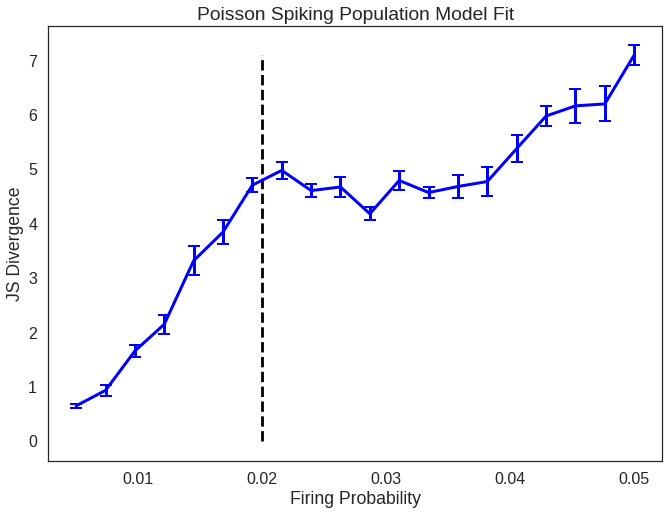

In [106]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, KL, yerr=KLerr, linewidth=3, capsize=6, capthick=2, fmt='b')
#plt.ylim(0, 0.46)
plt.plot(a*np.ones((20, 1)), np.linspace(0, np.amax(KL), 20), 'k--')
plt.xlabel('Firing Probability')
plt.ylabel('JS Divergence')
plt.title('Poisson Spiking Population Model Fit')
#plt.savefig('/Users/brad/PoissonFit-{}.pdf'.format(a), format='pdf')

In [23]:
# Compute SCG for each sample
# Old JS divergence
SCGs = []
for ind in range(nsamples):
    msimps = sc.binarytomaxsimplex(binMat=binMatsamples[:, :, ind], rDup=True)
    E = sc.simplicialChainGroups(msimps)
    SCGs.append(E)
Edata = SCGs[0]


est_save = []
ntrials = 1
X = np.linspace(0.005, 0.08, 50)

beta = -0.15

for t in range(ntrials):
    print(t)
    KL=[]
    JS = []
    KLerr = []
    JSerr = []
    for x in tqdm.tqdm(X):
        (m, mjs, stderr, stderrjs) = loss_old_JS(x, beta)
        KL.append(m)
        JS.append(mjs)
        KLerr.append(stderr)
        JSerr.append(stderrjs)
        
    
    index_min = np.argmin(KL)
    est_save.append(X[index_min])

  0%|          | 0/50 [00:00<?, ?it/s]

0
error2
error2
error2
error2
error2
error2
error2
error2
error2


  2%|▏         | 1/50 [00:00<00:11,  4.38it/s]

error2
error2
error2
error2
error2


  4%|▍         | 2/50 [00:00<00:11,  4.08it/s]

error2
error2
error2
error2


  6%|▌         | 3/50 [00:00<00:12,  3.72it/s]

error2
error2
error2


  8%|▊         | 4/50 [00:01<00:12,  3.68it/s]

error2
error2
error2


 10%|█         | 5/50 [00:01<00:12,  3.69it/s]

error2
error2


 12%|█▏        | 6/50 [00:01<00:11,  3.71it/s]

error2
error2


100%|██████████| 50/50 [00:57<00:00,  2.16s/it]


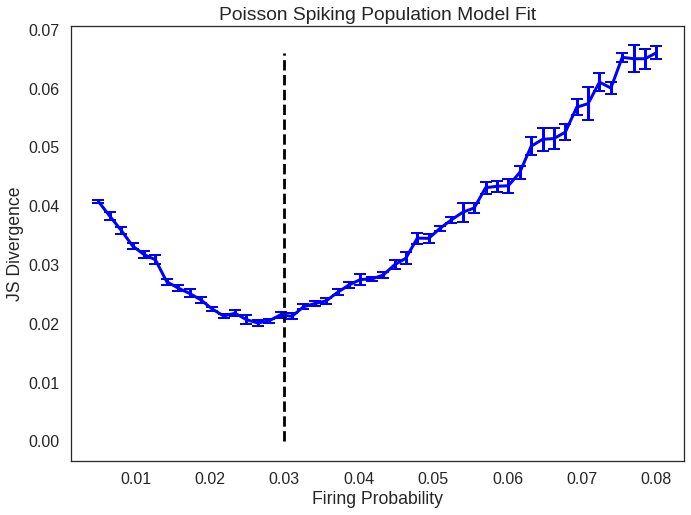

In [24]:
sns.set_style('white')
plt.figure(figsize=(11,8))
plt.errorbar(X, JS, yerr=JSerr, linewidth=3, capsize=6, capthick=2, fmt='b')
#plt.ylim(0, 0.46)
plt.plot(a*np.ones((20, 1)), np.linspace(0, np.amax(JS), 20), 'k--')
plt.xlabel('Firing Probability')
plt.ylabel('JS Divergence')
plt.title('Poisson Spiking Population Model Fit')
#plt.savefig('/Users/brad/PoissonFit-{}.pdf'.format(a), format='pdf')

In [41]:
testA = sc.simplicialChainGroups([(1,2,3)])
testB = sc.simplicialChainGroups([(1,2), (2,3), (1,3)])
LA = sc.compute_laplacian(testA, 1)
LB = sc.compute_laplacian(testB, 1)
(LB, LA) = sc.reconcile_laplacians(LB, LA)
Da = sc.densityMatrix(LA, -0.15)
Db = sc.densityMatrix(LB, -0.15)
sc.KLdivergence(Da, Db)

error2


0.033875082830867265